In [46]:
"""
Array Segmentation using Watershed + DBSCAN
Segments objects arranged in a rectangular array pattern
"""

import numpy as np
import cv2
from scipy import ndimage
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage.segmentation import watershed


def preprocess_image(image):
    """
    Preprocess image for segmentation
    
    Parameters:
    -----------
    image : ndarray
        Input image (grayscale or color)
    
    Returns:
    --------
    binary : ndarray
        Binary thresholded image
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Otsu's thresholding
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    return binary


def apply_watershed(binary_image):
    """
    Apply watershed segmentation
    
    Parameters:
    -----------
    binary_image : ndarray
        Binary image
    
    Returns:
    --------
    labels : ndarray
        Labeled regions from watershed
    """
    # Compute distance transform
    distance = ndimage.distance_transform_edt(binary_image)
    
    # Find local maxima
    local_max = peak_local_max(distance, min_distance=20, labels=binary_image)
    
    # Create markers
    markers = np.zeros_like(binary_image, dtype=int)
    markers[tuple(local_max.T)] = np.arange(1, len(local_max) + 1)
    
    # Apply watershed
    labels = watershed(-distance, markers, mask=binary_image)
    
    return labels


def extract_centroids(labels):
    """
    Extract centroids from labeled regions
    
    Parameters:
    -----------
    labels : ndarray
        Labeled regions
    
    Returns:
    --------
    centroids : ndarray
        Array of (x, y) centroid coordinates
    regions : list
        List of region properties
    """
    centroids = []
    regions = []
    
    for region_id in range(1, labels.max() + 1):
        mask = (labels == region_id)
        
        # Calculate centroid
        y_coords, x_coords = np.where(mask)
        if len(x_coords) > 0:
            cx = np.mean(x_coords)
            cy = np.mean(y_coords)
            area = len(x_coords)
            
            centroids.append([cx, cy])
            regions.append({
                'id': region_id,
                'centroid': (cx, cy),
                'area': area,
                'mask': mask
            })
    
    return np.array(centroids), regions


def cluster_with_dbscan(centroids, eps=250, min_samples=3):
    """
    Cluster centroids using DBSCAN to identify rectangular array pattern
    
    Parameters:
    -----------
    centroids : ndarray
        Array of centroid coordinates
    eps : float
        DBSCAN epsilon parameter
    min_samples : int
        DBSCAN minimum samples parameter
    
    Returns:
    --------
    cluster_labels : ndarray
        Cluster labels for each centroid
    """
    if len(centroids) == 0:
        return np.array([])
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(centroids)
    
    return cluster_labels


def segment_array(image_path, eps=50, min_samples=3, visualize=True):
    """
    Complete segmentation pipeline for rectangular array of objects
    
    Parameters:
    -----------
    image_path : str
        Path to input image
    eps : float
        DBSCAN epsilon parameter
    min_samples : int
        DBSCAN minimum samples parameter
    visualize : bool
        Whether to display visualization
    
    Returns:
    --------
    results : dict
        Dictionary containing segmentation results
    """
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image: {image_path}")
    
    # Preprocess
    binary = preprocess_image(image)
    
    # Apply watershed
    labels = apply_watershed(binary)
    
    # Extract centroids
    centroids, regions = extract_centroids(labels)
    
    # Cluster with DBSCAN
    cluster_labels = cluster_with_dbscan(centroids, eps=eps, min_samples=min_samples)
    
    # Prepare results
    results = {
        'image': image,
        'binary': binary,
        'labels': labels,
        'centroids': centroids,
        'regions': regions,
        'cluster_labels': cluster_labels,
        'n_clusters': len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    }
    
    if visualize:
        visualize_results(results)
    
    return results


def visualize_results(results):
    """
    Visualize segmentation results
    
    Parameters:
    -----------
    results : dict
        Results dictionary from segment_array
    """
    image = results['image']
    binary = results['binary']
    labels = results['labels']
    centroids = results['centroids']
    cluster_labels = results['cluster_labels']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Original image
    axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Binary image
    axes[0, 1].imshow(binary, cmap='gray')
    axes[0, 1].set_title('Binary Threshold')
    axes[0, 1].axis('off')
    
    # Watershed labels
    axes[1, 0].imshow(labels, cmap='nipy_spectral')
    axes[1, 0].set_title(f'Watershed Segmentation ({labels.max()} regions)')
    axes[1, 0].axis('off')
    
    # DBSCAN clustering
    axes[1, 1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Plot centroids colored by cluster
    unique_clusters = set(cluster_labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_clusters)))
    
    for cluster_id, color in zip(unique_clusters, colors):
        mask = cluster_labels == cluster_id
        cluster_centroids = centroids[mask]
        
        if cluster_id == -1:
            # Noise points in black
            axes[1, 1].scatter(cluster_centroids[:, 0], cluster_centroids[:, 1], 
                             c='black', s=100, alpha=0.5, marker='x', label='Noise')
        else:
            axes[1, 1].scatter(cluster_centroids[:, 0], cluster_centroids[:, 1], 
                             c=[color], s=100, alpha=0.7, label=f'Cluster {cluster_id}')
    
    axes[1, 1].set_title(f'DBSCAN Clustering (eps={results.get("eps", "N/A")})')
    axes[1, 1].legend()
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nSegmentation Statistics:")
    print(f"  Total regions detected: {labels.max()}")
    print(f"  Clusters found: {results['n_clusters']}")
    print(f"  Noise points: {np.sum(cluster_labels == -1)}")
    
    for cluster_id in set(cluster_labels):
        if cluster_id != -1:
            count = np.sum(cluster_labels == cluster_id)
            print(f"  Cluster {cluster_id}: {count} objects")


def batch_process(image_files, eps=50, min_samples=3):
    """
    Process multiple images
    
    Parameters:
    -----------
    image_files : list
        List of image file paths
    eps : float
        DBSCAN epsilon parameter
    min_samples : int
        DBSCAN minimum samples parameter
    
    Returns:
    --------
    all_results : list
        List of results dictionaries
    """
    all_results = []
    
    for img_file in image_files:
        print(f"\nProcessing: {img_file}")
        try:
            results = segment_array(img_file, eps=eps, min_samples=min_samples, visualize=False)
            all_results.append({
                'filename': img_file,
                'results': results
            })
            print(f"  ✓ Found {results['n_clusters']} clusters, {len(results['centroids'])} total objects")
        except Exception as e:
            print(f"  ✗ Error: {str(e)}")
            all_results.append({
                'filename': img_file,
                'error': str(e)
            })
    
    return all_results


Processing: Set1.bmp
  ✓ Found 1 clusters, 431 total objects

Processing: Array_2.bmp
  ✓ Found 1 clusters, 430 total objects

Processing: Array_3.bmp
  ✓ Found 1 clusters, 405 total objects

Processing: Array_4.bmp
  ✓ Found 4 clusters, 338 total objects

Processing: Array_5.bmp
  ✓ Found 3 clusters, 339 total objects

Processing: Array_6.bmp
  ✓ Found 1 clusters, 420 total objects

Processing: Array_7.bmp
  ✓ Found 1 clusters, 414 total objects

Processing: Array_8.bmp
  ✓ Found 1 clusters, 426 total objects

Processing: Array_9.bmp
  ✓ Found 1 clusters, 423 total objects

Processing: Array_10.bmp
  ✓ Found 1 clusters, 414 total objects


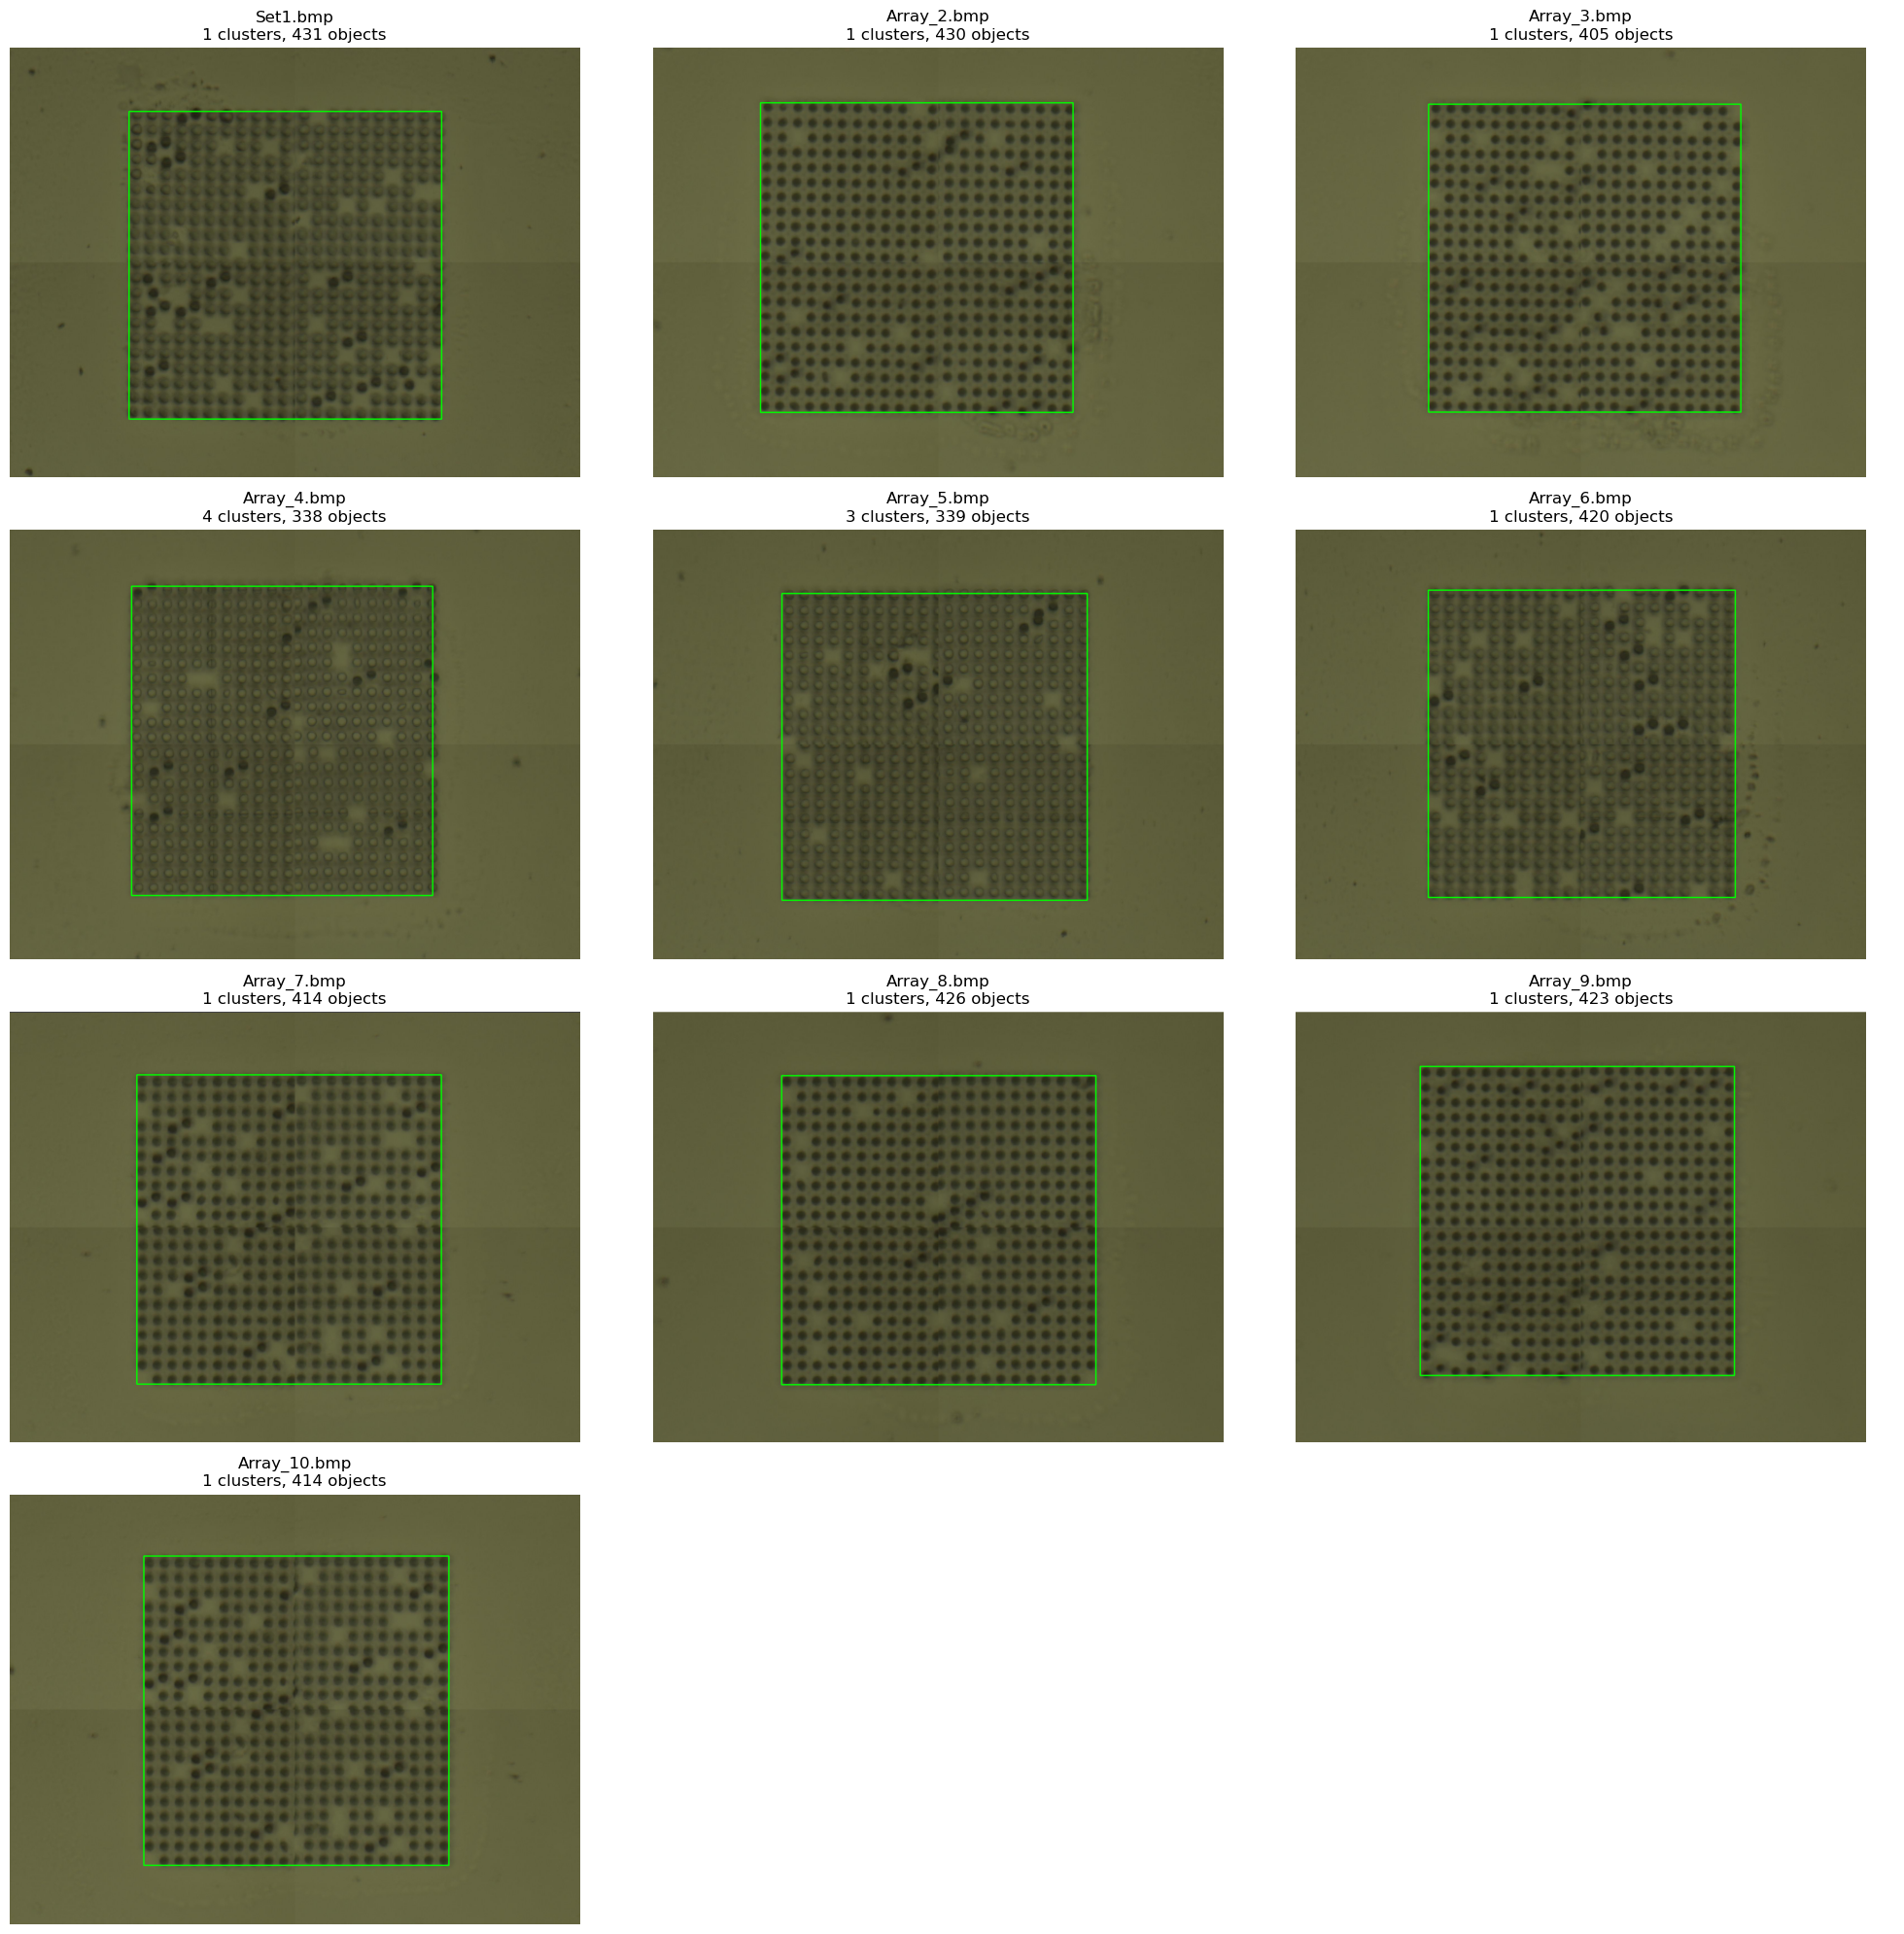

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from array_segmentation import segment_array, batch_process

# Define image files
image_files = ["Set1.bmp"] + [f"Array_{x}.bmp" for x in range(2, 10+1)]

# Process all images with high eps to get single cluster
all_results = batch_process(image_files, eps=110, min_samples=11
                           )

# Visualize with bounding boxes
n_images = len(all_results)
cols = 3
rows = (n_images + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
axes = axes.flatten()

for i, result_dict in enumerate(all_results):
    if 'error' in result_dict:
        axes[i].text(0.5, 0.5, f"Error: {result_dict['filename']}", ha='center', va='center')
        axes[i].axis('off')
        continue
    
    results = result_dict['results']
    image = results['image'].copy()
    centroids = results['centroids']
    cluster_labels = results['cluster_labels']
    
    # Get main cluster (not noise)
    main_cluster_mask = cluster_labels != -1
    if np.any(main_cluster_mask):
        main_centroids = centroids[main_cluster_mask]
        
        # Percentile trimming removes outer artifacts
        x_min = int(np.percentile(main_centroids[:, 0], 2))
        x_max = int(np.percentile(main_centroids[:, 0], 97))
        y_min = int(np.percentile(main_centroids[:, 1], 2))
        y_max = int(np.percentile(main_centroids[:, 1], 97))

        # Add padding
        padding = 20
        x_min = max(0, x_min - padding)
        y_min = max(0, y_min - padding)
        x_max = min(image.shape[1], x_max + padding)
        y_max = min(image.shape[0], y_max + padding)
        
        # Draw bounding box
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
    
    axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"{result_dict['filename']}\n{results['n_clusters']} clusters, {len(centroids)} objects")
    axes[i].axis('off')

for i in range(n_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()